In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries used
from models.grid_world import Experiment
from models.agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent, MetaAgent
from models.experiment_designs.experiment_3a import gen_task_param as gen_task_param_a
from models.experiment_designs.experiment_3b import gen_task_param as gen_task_param_b

sns.set_context('paper', font_scale=1.5)

In [2]:
n_sims_a = 49
n_sims_b = 80

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = -0.5
alpha_scale = 1.0

inv_temp = 10.0
goal_prior = 1e-10 
mapping_prior = 1e-10
pruning_threshold = 500.0
evaluate = False

np.random.seed(0)

# pre generate a set of tasks for consistency. 
list_tasks_a = [gen_task_param_a() for _ in range(n_sims_a)]
list_tasks_b = [gen_task_param_b() for _ in range(n_sims_b)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims_a + n_sims_b)]


def sim_agent(AgentClass, name='None', flat=False, meta=False):
    tt = 0


    results = []
    for task, list_task in zip(['A', 'B'], [list_tasks_a, list_tasks_b]):
         
        for ii, (task_args, task_kwargs) in tqdm(enumerate(list_task), total=len(list_task)):
            if not flat:
                agent_kwargs = dict(alpha=list_alpha[tt], inv_temp=inv_temp, 
                                    goal_prior=goal_prior, mapping_prior=mapping_prior)
            else:
                agent_kwargs = dict(inv_temp=inv_temp, goal_prior=goal_prior, mapping_prior=mapping_prior)   
                
            if meta:
                p = np.random.uniform(0, 1)
                agent_kwargs['mix_biases'] = [np.log(p), np.log(1-p)]
                agent_kwargs['update_new_c_only'] = True
            
            agent = AgentClass(Experiment(*task_args, **task_kwargs), **agent_kwargs)

            _res = agent.generate(evaluate=evaluate, pruning_threshold=pruning_threshold)
            _res[u'Model'] = name
            _res[u'Iteration'] = [tt] * len(_res)
            _res[u'Task'] = [task] * len(_res)
            results.append(_res)
            tt += 1
    
        
    return pd.concat(results)


In [3]:
results_ic = sim_agent(IndependentClusterAgent, name='Independent')
results_jc = sim_agent(JointClusteringAgent, name='Joint')
results_fl = sim_agent(FlatAgent, name='Flat', flat=True)
results_meta = sim_agent(MetaAgent, name='Meta', meta=True)
results = pd.concat([results_ic, results_jc, results_fl, results_meta], sort=False)

100%|██████████| 80/80 [00:23<00:00,  3.38it/s]


/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/envs/compgen/lib/python2.7/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


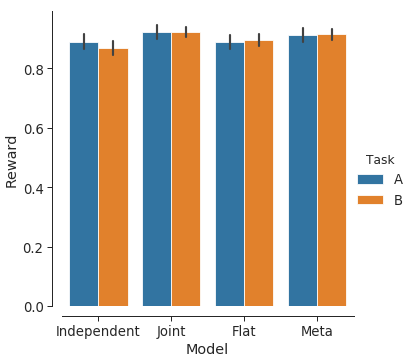

In [4]:
with sns.axes_style('ticks'):
    df0 = results[results['In Goal'] & (results.Context <= 2)]
    sns.factorplot(hue='Task', y='Reward', data=df0, kind='bar',
                  x='Model', units='Iteration')
    sns.despine(offset=10)

/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


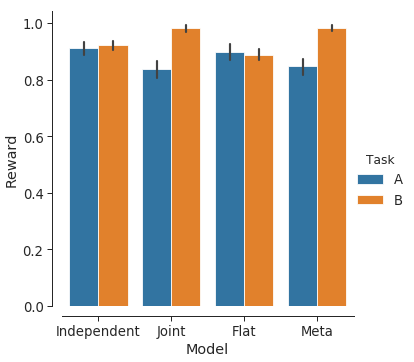

In [5]:
with sns.axes_style('ticks'):
    df0 = results[results['In Goal'] & (results.Context > 2)]
    sns.factorplot(hue='Task', y='Reward', data=df0, kind='bar',
                  x='Model', units='Iteration')
    sns.despine(offset=10)

/anaconda3/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/envs/compgen/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note tha

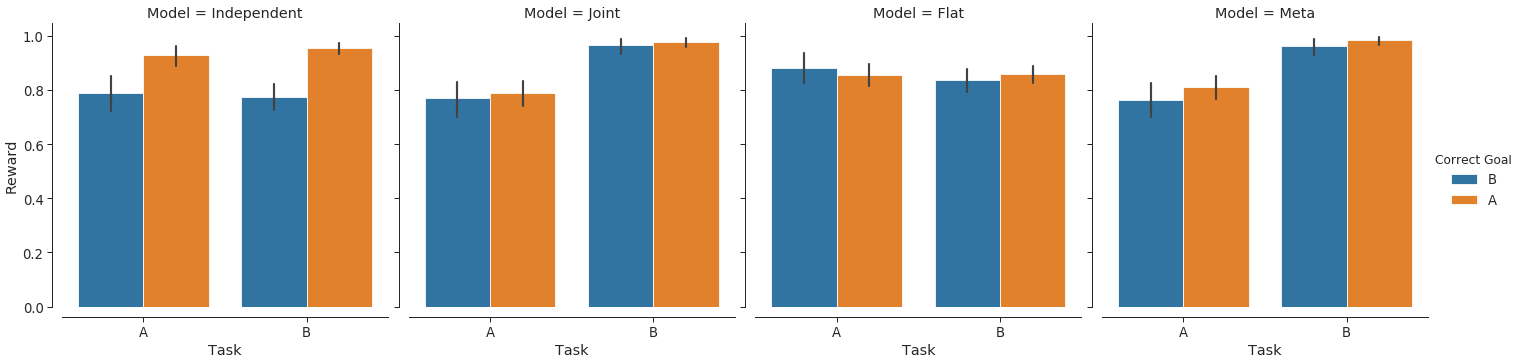

In [6]:
with sns.axes_style('ticks'):
    df0 = results[results['In Goal'] & (results.Context > 2) & 
                  (results['Times Seen Context'] <= 4)]
    df0['Correct Goal'] = ['A'] * len(df0)
    df0.loc[df0.Context == 5, 'Correct Goal'] = 'B'
    sns.factorplot(
        hue='Correct Goal', y='Reward', data=df0, kind='bar', col='Model',
        x='Task', units='Iteration'
    )
    sns.despine(offset=10)

/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


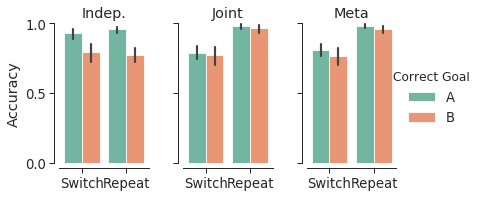

In [7]:
with sns.axes_style('ticks'):
    df0 = results[results['In Goal'] & (results.Context > 2) & 
                  (results['Times Seen Context'] <= 4) & (results['Model'] != 'Flat')].copy()
    df0['Correct Goal'] = ['A'] * len(df0)
    df0.loc[df0.Context == 5, 'Correct Goal'] = 'B'
    g = sns.factorplot(
        hue='Correct Goal', y='Reward', data=df0, kind='bar', col='Model',
        x='Task', units='Iteration', hue_order=['A', 'B'],
        palette='Set2', size=3.0, aspect=0.63
    )
    sns.despine(offset=5)
    
    g.set_xticklabels('Switch Repeat'.split())
    g.set_xlabels('')
    g.set_ylabels('Accuracy')
    g.axes[0][0].set_yticks(np.arange(0, 1.01, 0.5))
    g.axes[0][0].set_ylim(0, 1)
    
    g.axes[0][0].set_title('Indep.')
    g.axes[0][1].set_title('Joint')
    g.axes[0][2].set_title('Meta')



# Statistics
Here, we show the difference between the conditions of interest statistically for the model. 

In [8]:
df0 = results[results['In Goal'] & (results.Context > 2) & 
              (results['Times Seen Context'] <= 4) & (results['Model'] != 'Flat')].copy()
df0['Correct Goal'] = ['A'] * len(df0)
df0.loc[df0.Context == 5, 'Correct Goal'] = 'B'
df0['Acc'] = np.array(df0.loc[:, 'Reward'].values, dtype=np.float)
    
score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df['Correct Goal'] == 'A', :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[subj_df['Correct Goal'] == 'B', :].groupby('Times Seen Context').mean()['Acc']

        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['A v B'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
score = pd.concat(score) 

from scipy.stats import ttest_1samp, wilcoxon

def print_diff_stats(model_name):
    diff = score.groupby(['Model', 'Comparison','Iteration']).mean().reset_index()
    for c in set(score.Comparison):
        selection = (diff.Model == model_name) &(diff.Comparison == c)
        t, p = ttest_1samp(diff.loc[selection, 'Difference Score'].values, 0)
        df = len(diff.loc[selection, 'Difference Score'].values) - 1
        M = np.mean(diff.loc[selection, 'Difference Score'].values)
        print "%s: M=%.3g, t(%d)=%.5g, p=%.3g" % (c, M, df, t, p)
        print wilcoxon(diff.loc[selection, 'Difference Score'].values)

print_diff_stats('Independent')
print_diff_stats('Joint')
print_diff_stats('Meta')

A v B: M=0.165, t(128)=12.351, p=1.46e-23
WilcoxonResult(statistic=752.5, pvalue=2.8460548250994604e-16)
A v B: M=0.0155, t(128)=1.6437, p=0.103
WilcoxonResult(statistic=150.5, pvalue=0.08220975586372276)
A v B: M=0.031, t(128)=3.2866, p=0.00131
WilcoxonResult(statistic=187.0, pvalue=0.0034851273675468946)


In [9]:
from scipy.stats import ttest_ind, mannwhitneyu

def print_task_diff(model):
    model_df = df0[df0.Model == model]
    grouped = model_df.groupby(['Task', 'Iteration']).mean().reset_index()
    
    A = grouped.loc[grouped.Task == 'A', 'Acc']
    B = grouped.loc[grouped.Task == 'B', 'Acc']
    t, p = ttest_ind(A, B)
    df = len(A) + len(B) - 2
    M = np.mean(A) - np.mean(B)

    print "Comparison: M=%.3g, t(%d)=%.5g, p=%.3g" % (M, df, t, p)
    print mannwhitneyu(A, B)

print_task_diff('Independent')
print_task_diff('Joint')
print_task_diff('Meta')

Comparison: M=-0.0132, t(127)=-1.406, p=0.162
MannwhitneyuResult(statistic=1742.0, pvalue=0.10166714312212344)
Comparison: M=-0.193, t(127)=-16.219, p=9.71e-33
MannwhitneyuResult(statistic=219.5, pvalue=2.2865501220937994e-20)
Comparison: M=-0.181, t(127)=-16.615, p=1.2e-33
MannwhitneyuResult(statistic=146.5, pvalue=7.856841715845104e-22)


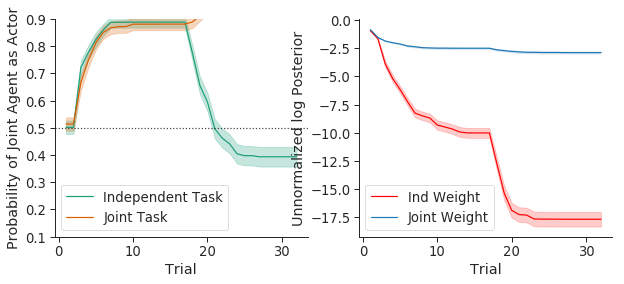

In [10]:
from matplotlib.ticker import NullFormatter

cc = sns.color_palette('Dark2')

with sns.axes_style('ticks'):

    df0 = results[(results['Steps Taken']==1) & 
                  (results['Model'] == 'Meta') & (results.Task == 'A')
                 ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims_a + n_sims_b)
    ax.plot(x, y, '-', color=cc[0], label='Independent Task')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25, color=cc[0])

    
    df0 = results[(results['Steps Taken']==1) & 
              (results['Model'] == 'Meta') & (results.Task == 'B')
             ].copy()

    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims_a + n_sims_b)
    ax.plot(x, y, '-',  color=cc[1], label='Joint Task')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25,  color=cc[1])
    ax.set_ylabel('Probability of Joint Agent as Actor')
    ax.set_xlabel('Trial')
    xlb, xub = ax.get_xlim()
    ax.plot([xlb, xub], [0.5, 0.5], 'k:', alpha=0.75)
    ax.set_xlim(xlb, xub)
    ax.set_ylim([0.1, 0.9])
    ax.legend()
    
    ax = axes[1]
    y = df0.groupby('Trial Number')['Ind Weight'].mean()
    y_err = df0.groupby('Trial Number')['Ind Weight'].std() / np.sqrt(n_sims_a + n_sims_b)
    ax.plot(x, y, 'r-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2, color='r')

    y = df0.groupby('Trial Number')['Joint Weight'].mean()
    y_err = df0.groupby('Trial Number')['Joint Weight'].std() / np.sqrt(n_sims_a + n_sims_b)
    ax.plot(x, y, '-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)
    plt.legend(loc='best')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Unnormalized log Posterior')    
    ax.set_xlim(xlb, xub)

    plt.subplots_adjust(hspace=0.3)
    sns.despine()
